# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents')
sys.path.append('../../../RL_lib/Policies/PPO')
sys.path.append('../../../RL_lib/Policies/Common')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Env')
sys.path.append('../../../Imaging')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/Asteroid_CPO_seeker-master/Experiments/Extended/Test_HF


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 1.0000000e+00  0.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]
[ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]
using max  pooling
V4: Output State type:  <function Sensor.optflow_state_range_dp1 at 0x137e99488>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x128592748>>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x128592748>>
6dof dynamics model 
thruster model: 
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Lander Model: 
Reward_terminal equator
queue fixed
Flat Constraint
Attitude Constraint
Rotational Velocity Constraint
Position Hysterises Constraint


<IPython.core.display.Javascript object>


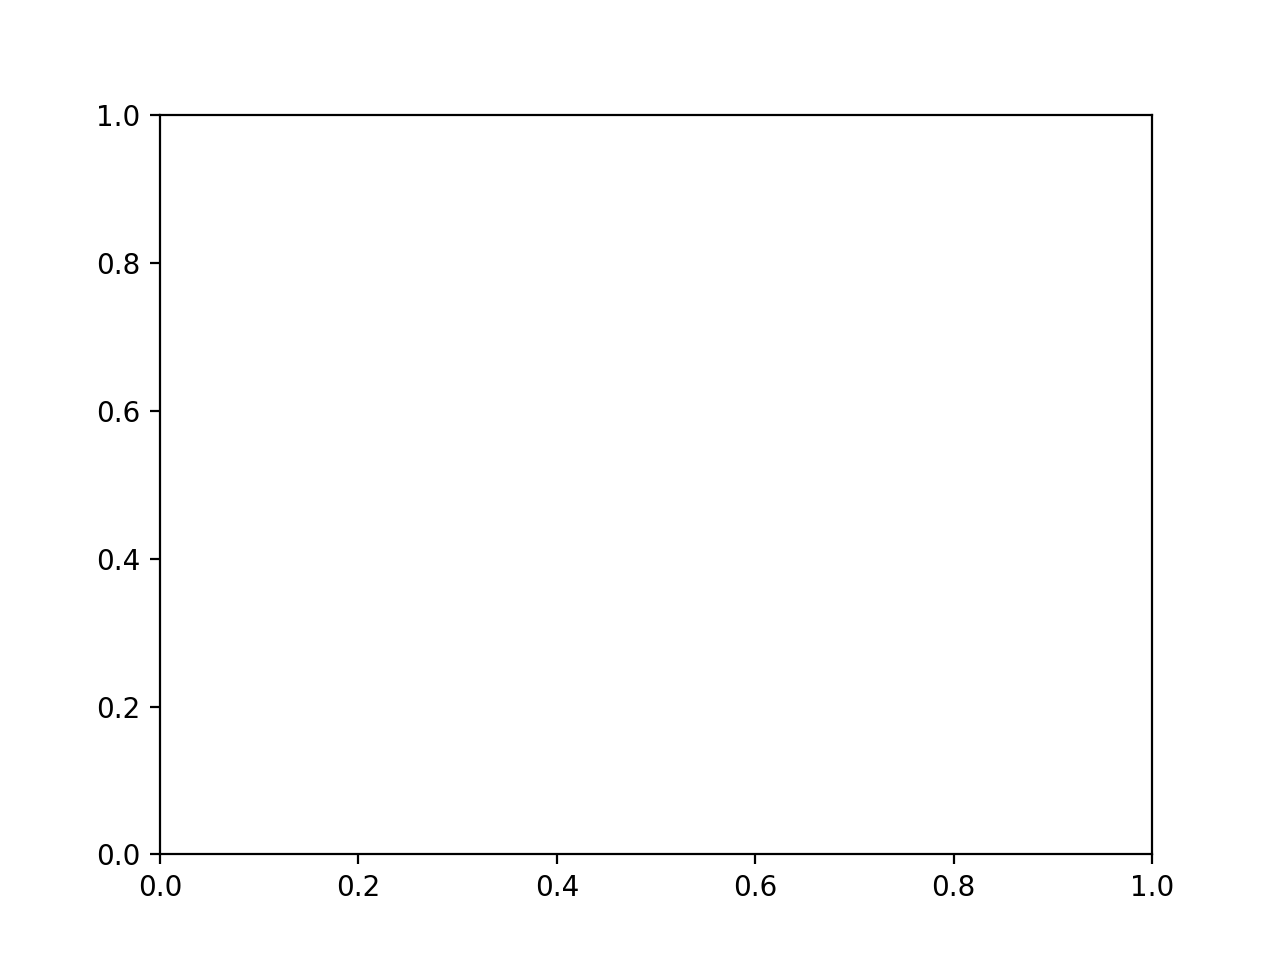

<IPython.core.display.Javascript object>


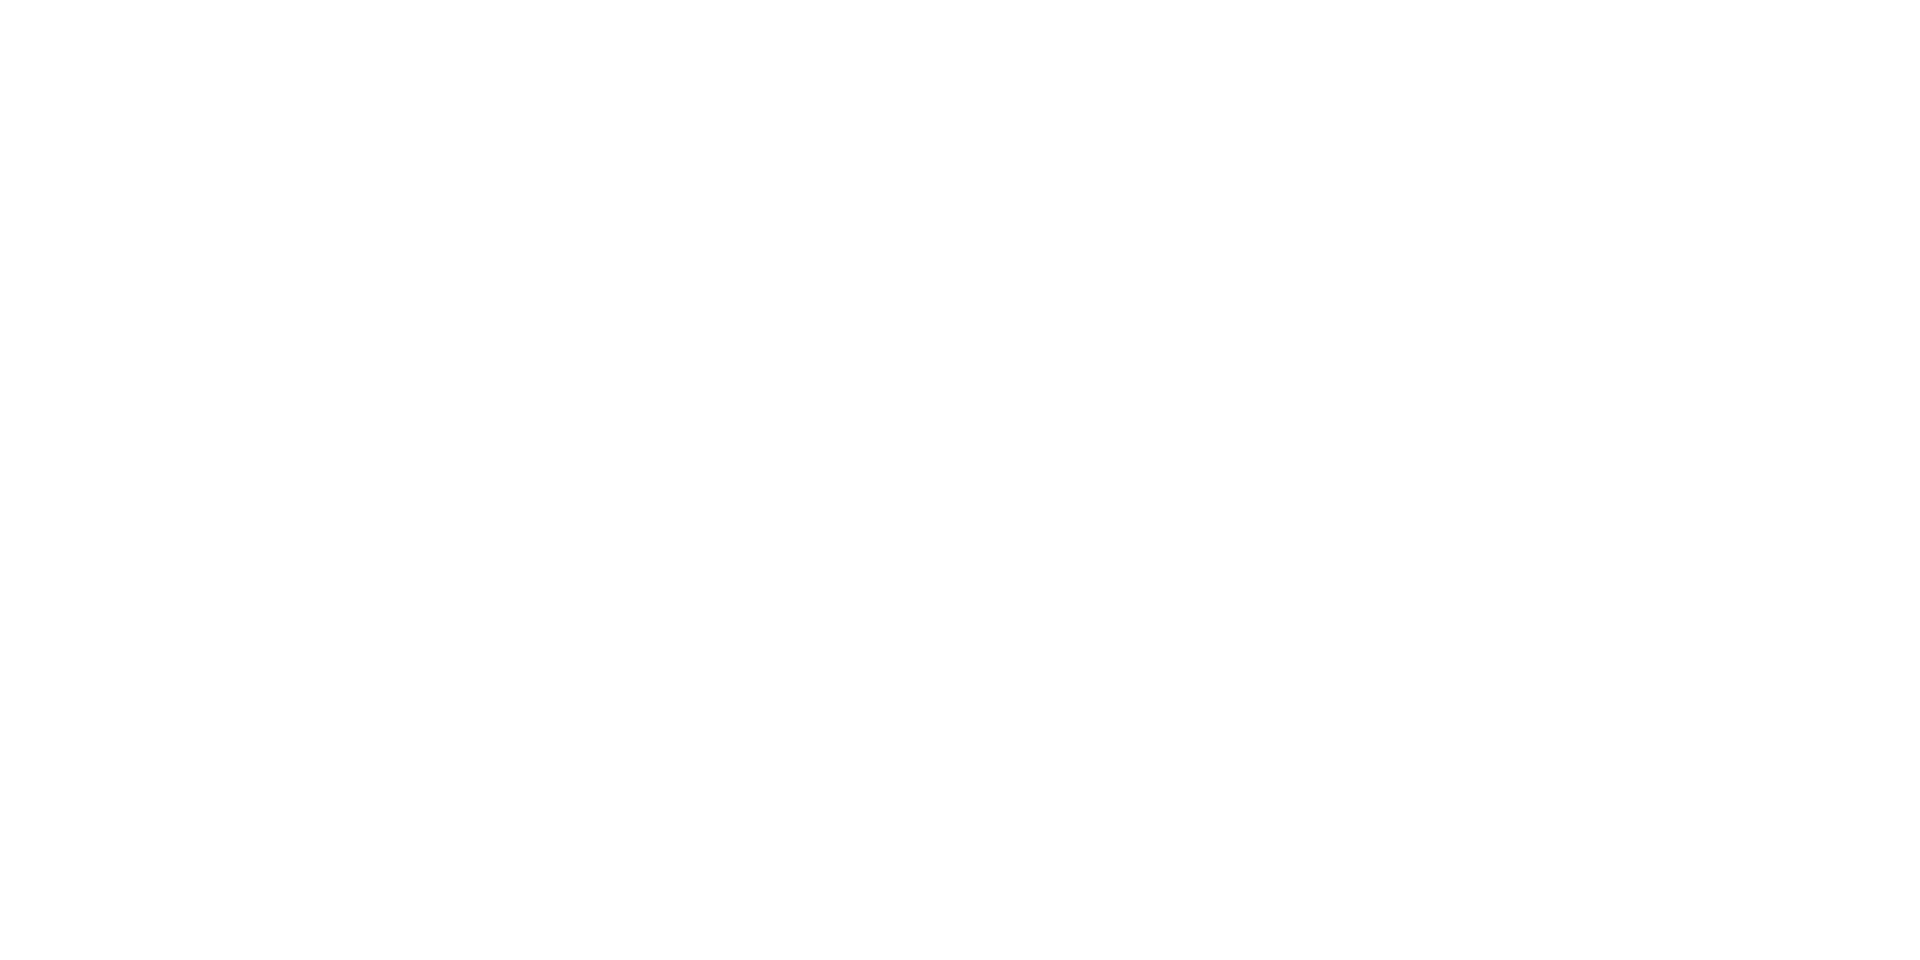

<IPython.core.display.Javascript object>


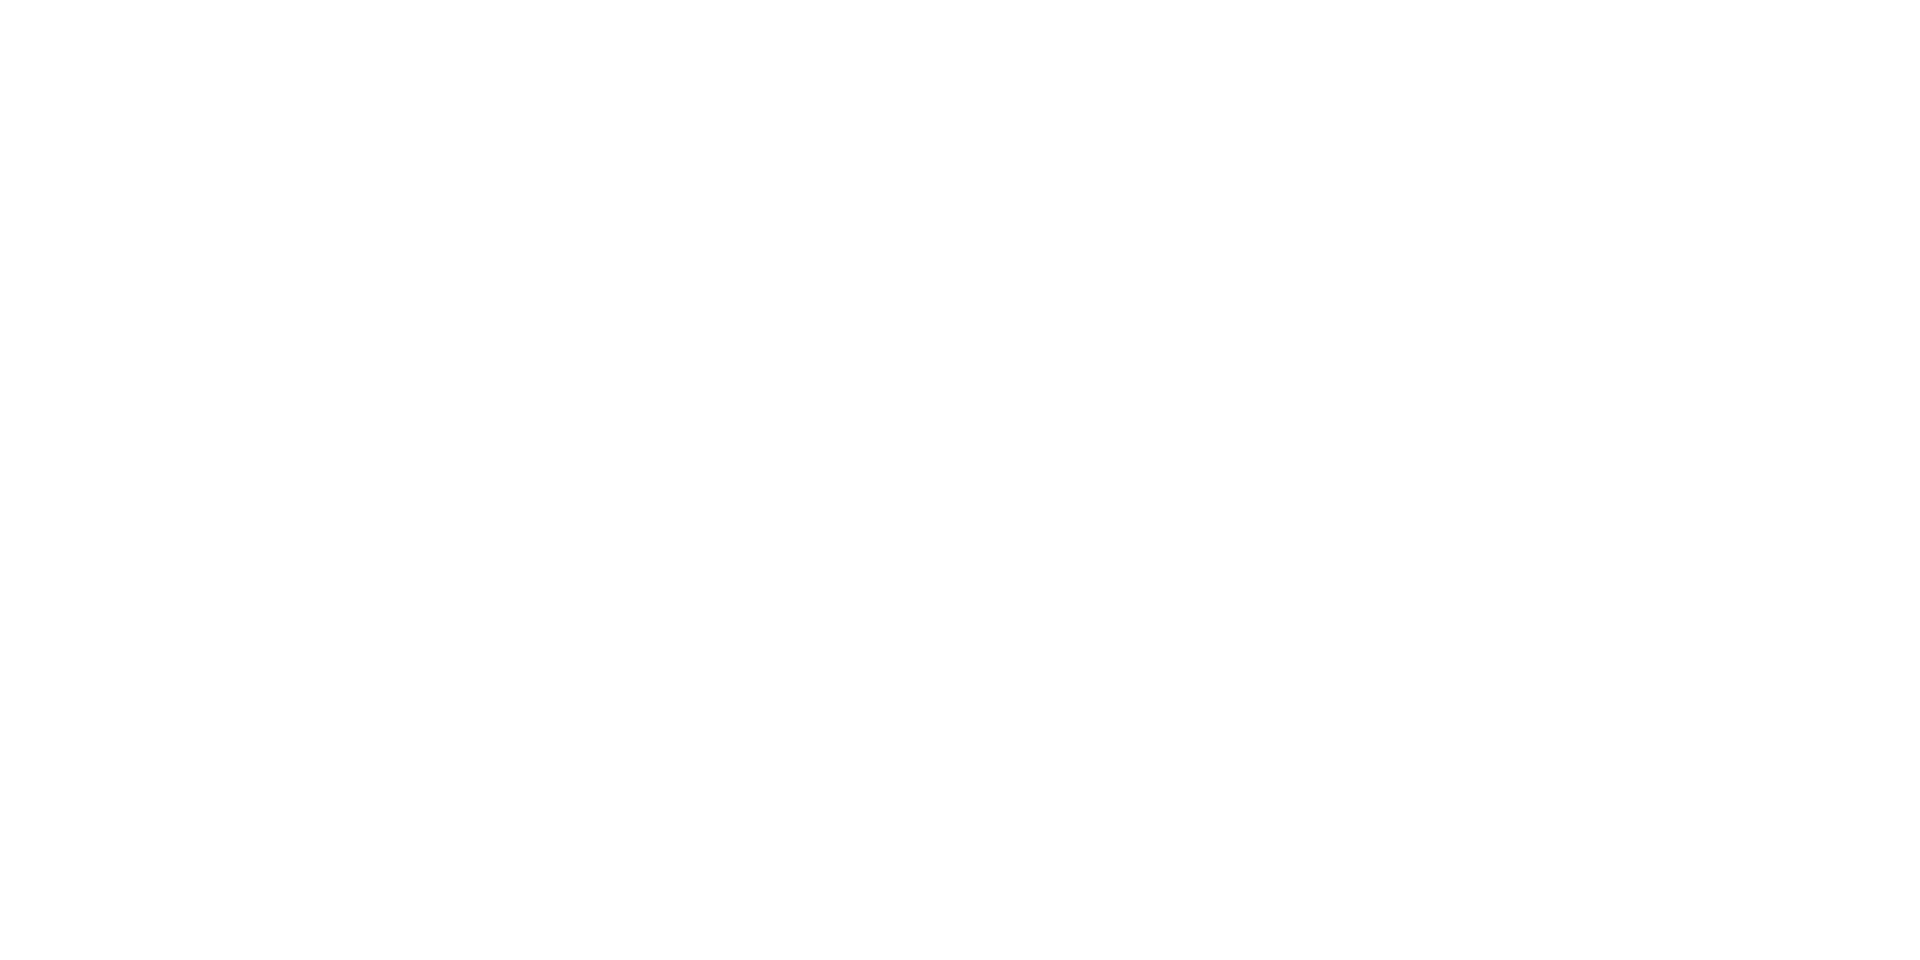

<IPython.core.display.Javascript object>


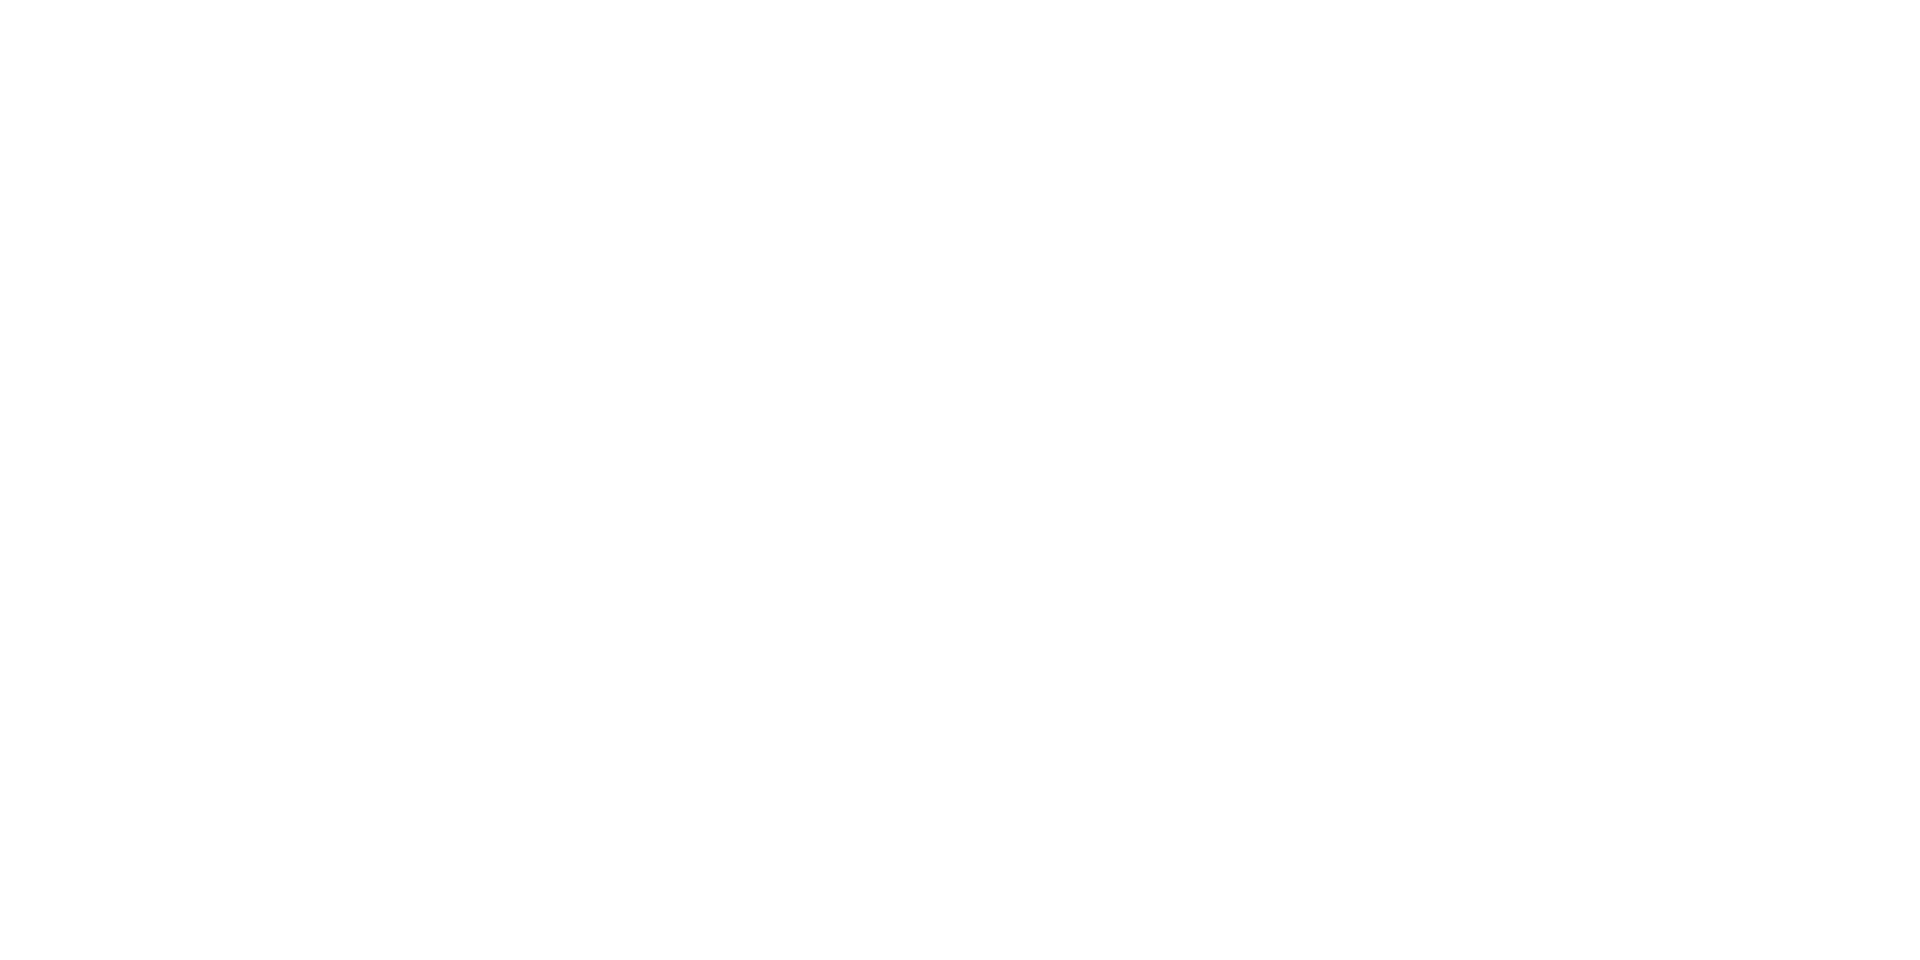

<IPython.core.display.Javascript object>


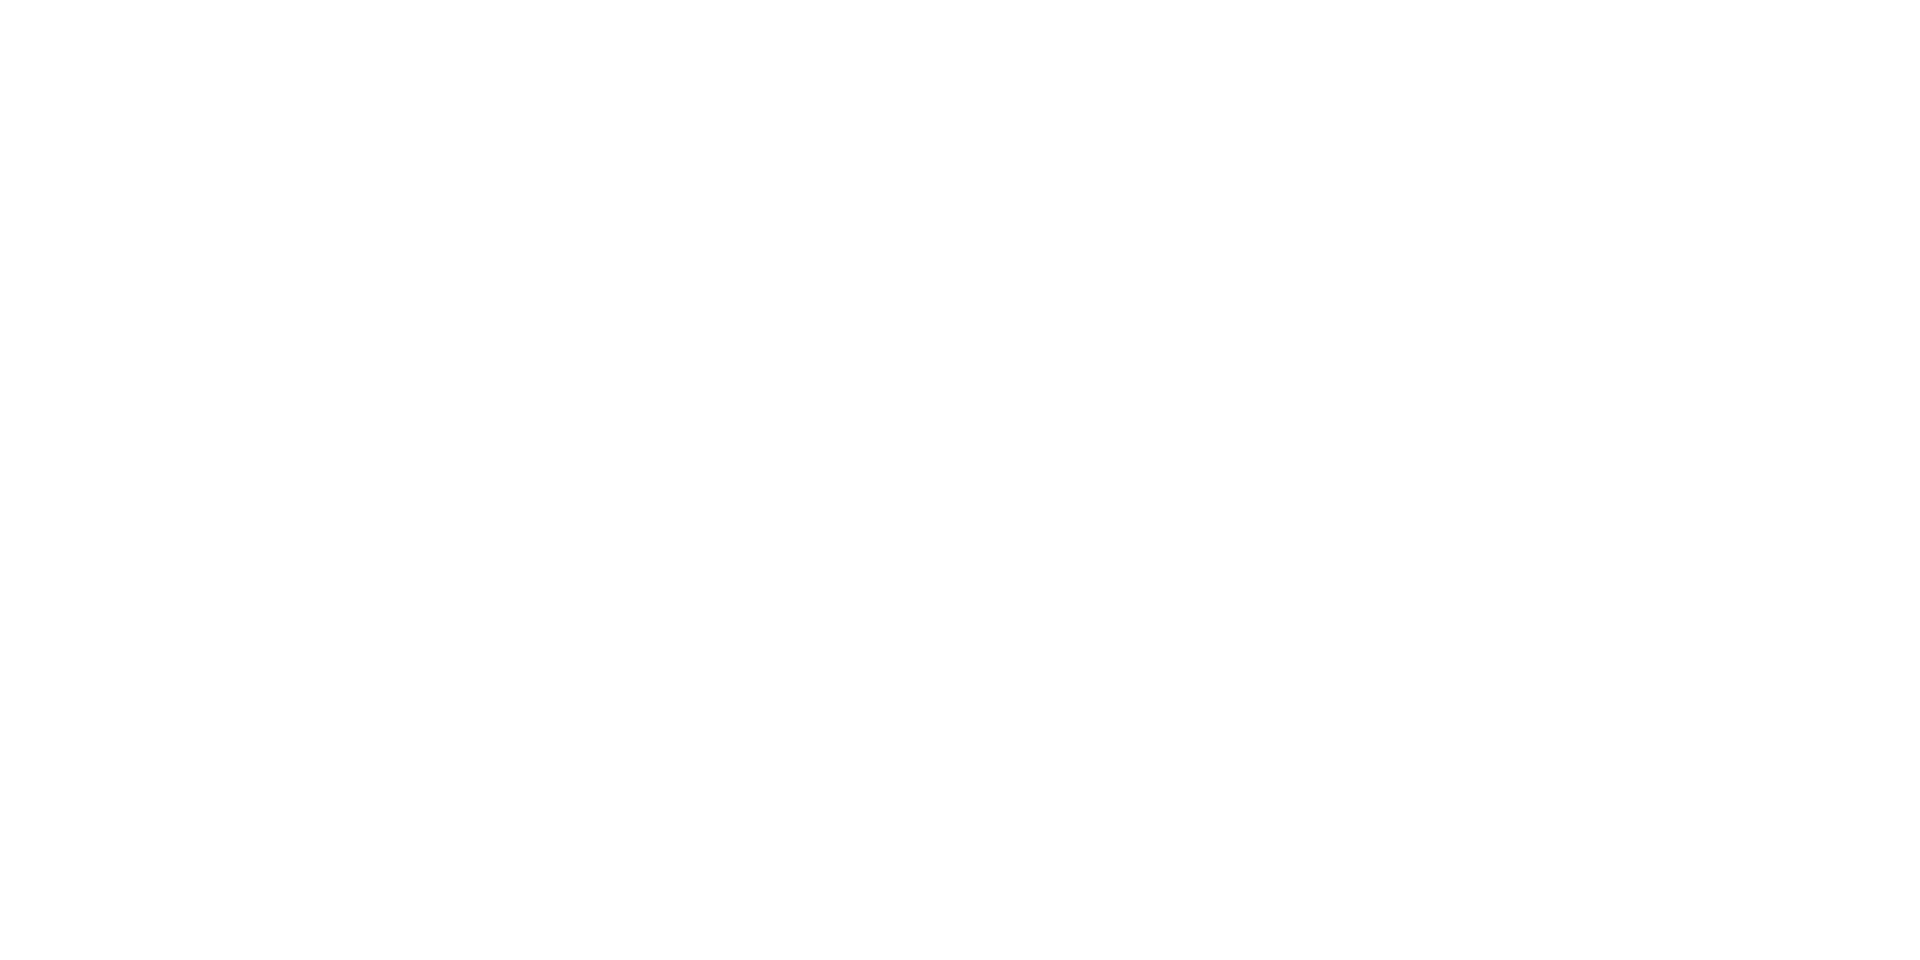

<IPython.core.display.Javascript object>


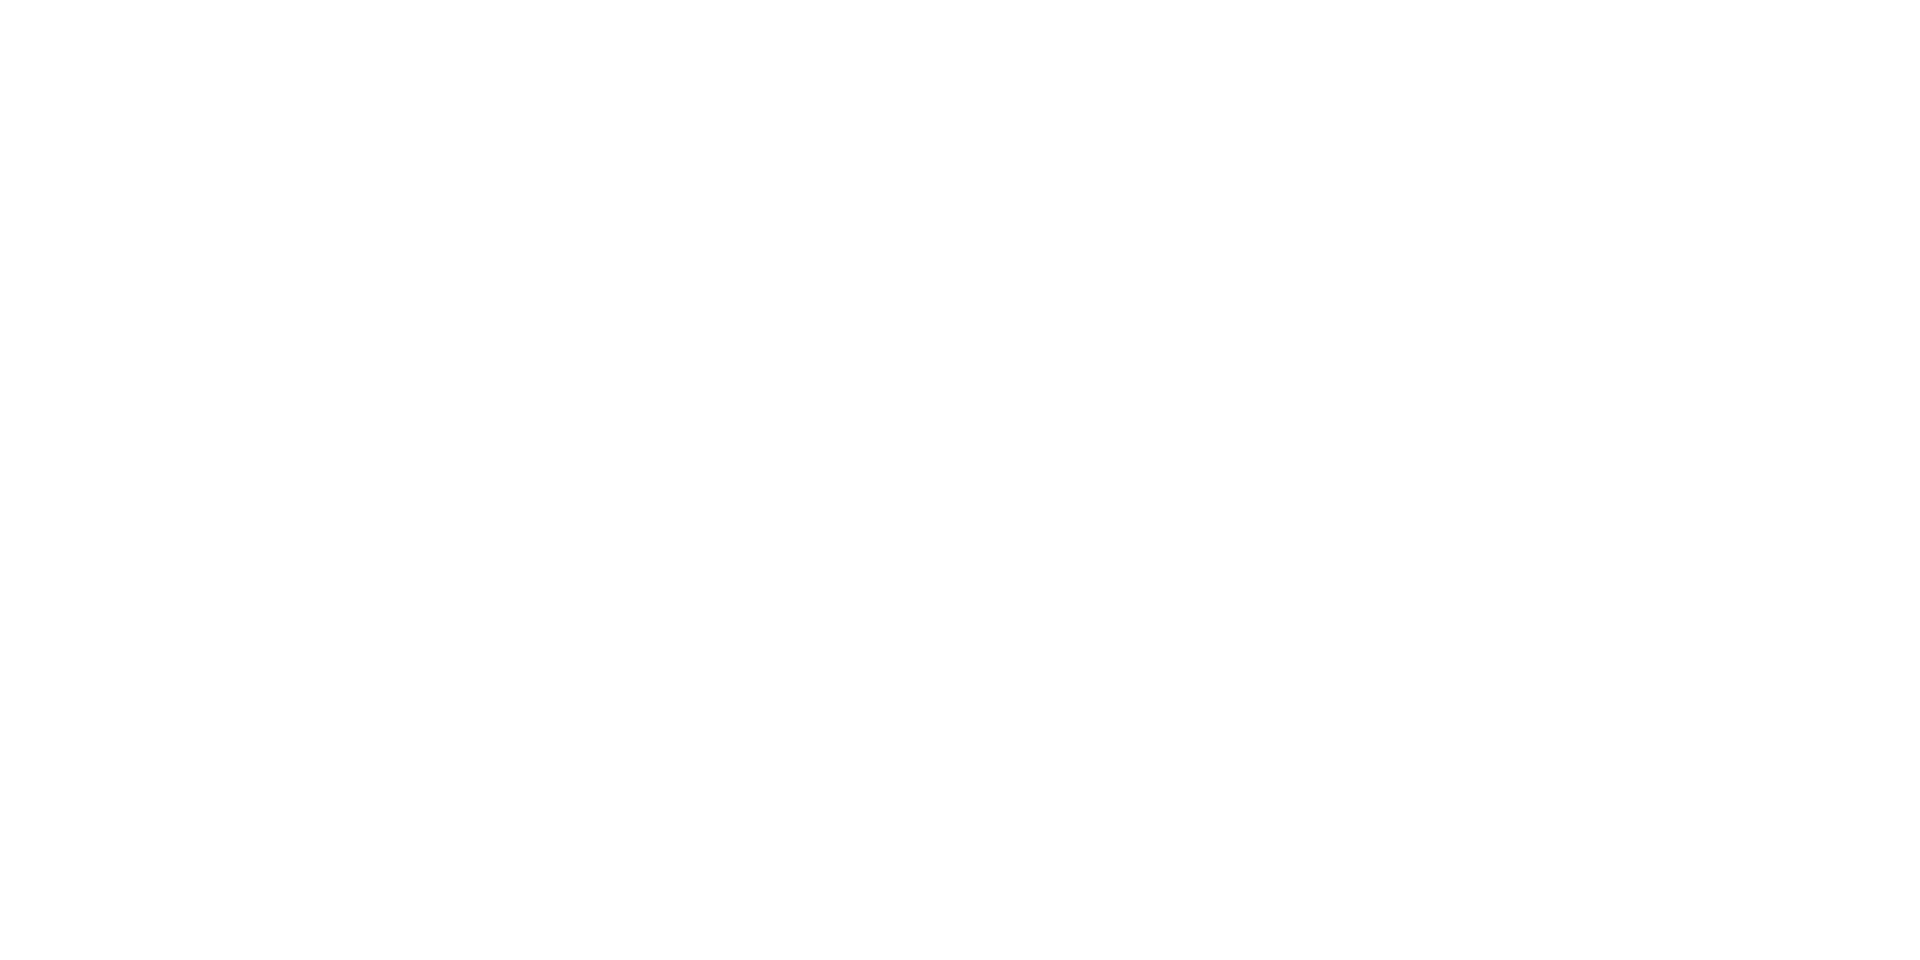

<IPython.core.display.Javascript object>


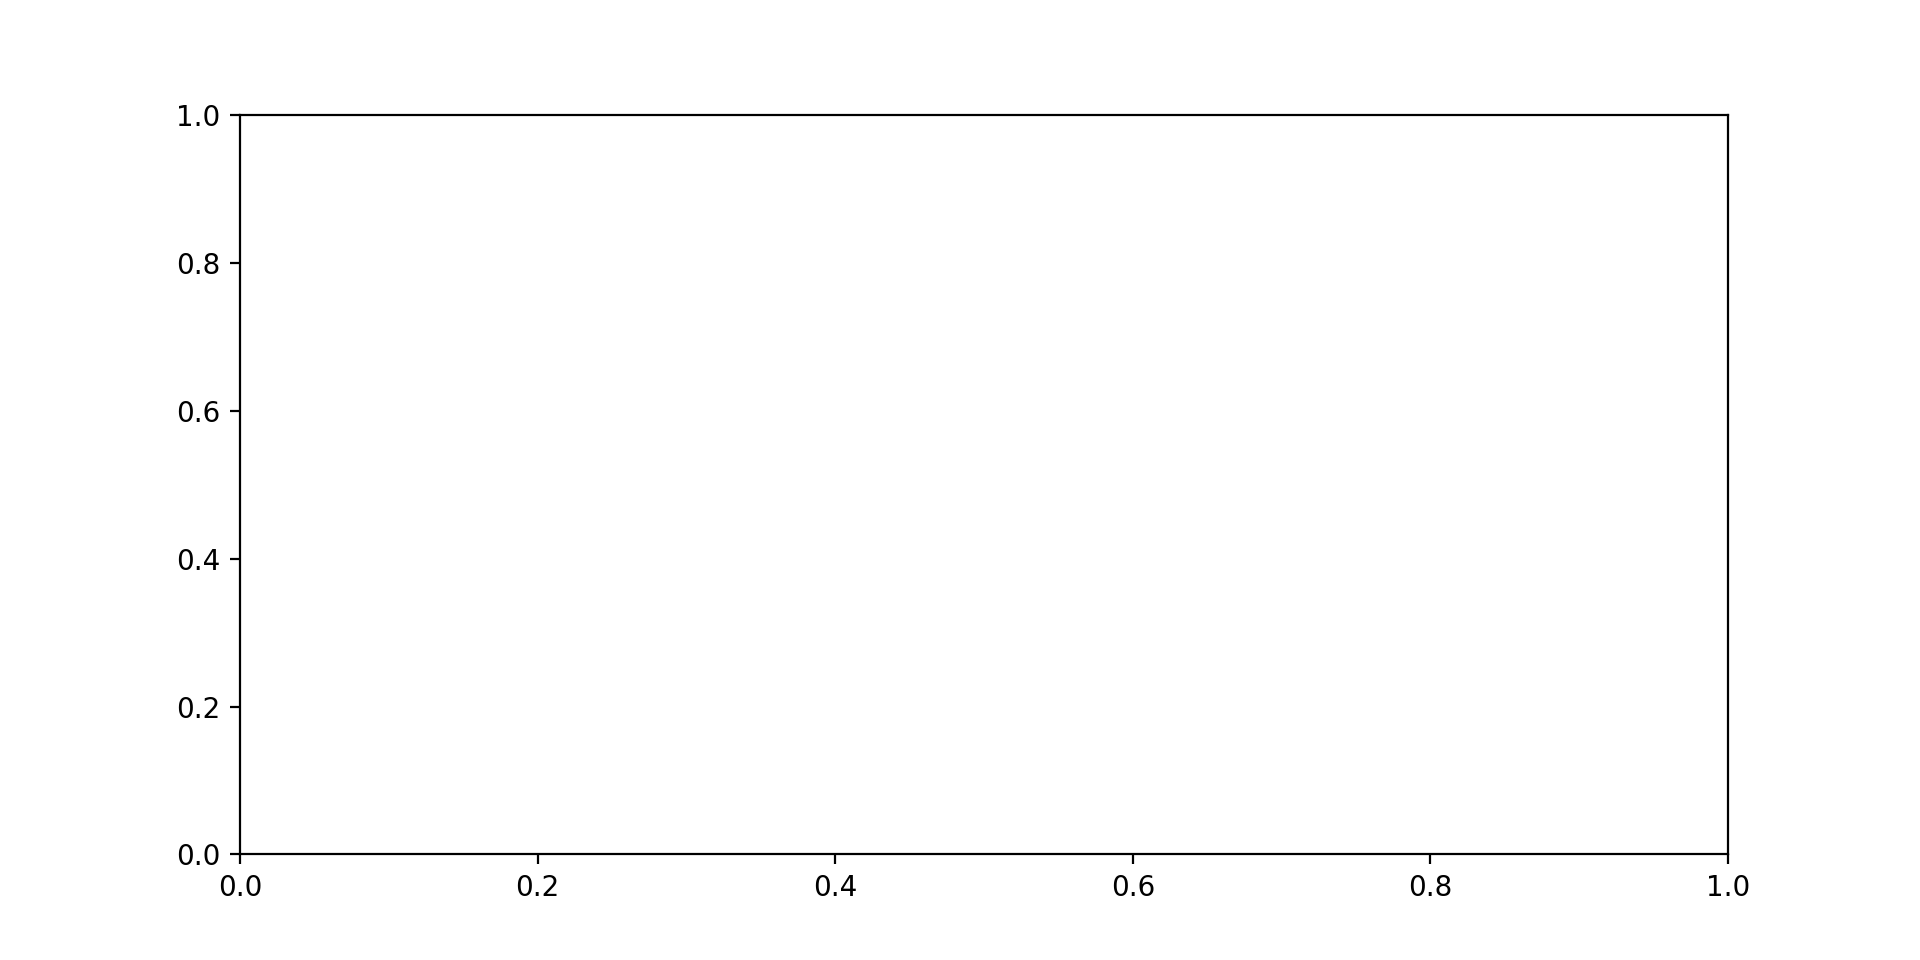

lander env RHL
Landing_icgen:
[[-1.]
 [ 1.]]
Policy with vectorized sample
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 176)
	xn_init: layer  Linear(in_features=176, out_features=240, bias=True)
	xn_init: layer  Linear(in_features=240, out_features=24, bias=True)
Policy: recurrent steps > 1, disabling shuffle
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Shuffle by Chunks:  False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
	Advantage Func:     <advantage_utils.Adv_default object at 0x139f6f438>
	Advantage Norm:     <function Adv_normalizer.apply at 0x13736e488>
	PD:                 <softmax_pd.Softmax_pd object at 0x139f6f208>
	Loss Function:      <bound method Policy.calc_loss1 of <policy_ppo.Policy object at 0x139f6f278>>
Value Funtion
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 25)
	xn_init: layer  Linear(in_feature

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
import rl_utils
import attitude_utils as attu
import optics_utils as optu
from arch_policy_vf import Arch

from policy_ppo import Policy
from softmax_pd import Softmax_pd as PD
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets


from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from rh_constraint import RH_constraint
from no_attitude_constraint import Attitude_constraint
from w_constraint import W_constraint
from reward_attitude import Reward
from hf_asteroid import Asteroid

from thruster_model_cubesat import Thruster_model

from sensor import Sensor
from seeker import Seeker

landing_site_range = 10.0
landing_site = None #np.asarray([-250.,0.,0.])

asteroid_model = Asteroid(landing_site_override=landing_site, omega_range=(1e-5,5e-4))

ap = attu.Quaternion_attitude()

C_cb = optu.rotate_optical_axis(0.0, 0.0, np.pi)
r_cb = np.asarray([0,0,0])
fov=envu.deg2rad(90)
seeker = Seeker(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb,
                radome_slope_bounds=(-0.05,0.05), range_bias=(-0.05,0.05),
                   fov=fov, debug=False)
sensor = Sensor(seeker, attitude_parameterization=ap,  use_range=True, apf_tau1=300, use_dp=False,
                      landing_site_range=landing_site_range,
                      pool_type='max', state_type=Sensor.optflow_state_range_dp1)
print(sensor.track_func)
sensor.track_func = sensor.track_func1
print(sensor.track_func)
logger = rl_utils.Logger()
dynamics_model = Dynamics_model(h=2)
thruster_model = Thruster_model(pulsed=True, scale=1.0, offset=0.4)
lander_model = Lander_model(asteroid_model, thruster_model, attitude_parameterization=ap, sensor=sensor, 
                             landing_site_range=landing_site_range, com_range=(-0.10,0.10),
                              attitude_bias=0.05, omega_bias=0.05)

lander_model.get_state_agent = lander_model.get_state_agent_sensor_att_w2

obs_dim = 13
action_dim = 12
actions_per_dim = 2
logit_dim = action_dim * actions_per_dim
recurrent_steps = 60

reward_object = Reward(landing_rlimit=2, landing_vlimit=0.1, 
                       tracking_bias=0.01, fov_coeff=-50., 
                       att_coeff=-0.20,
                       tracking_coeff=-0.5, magv_coeff=-1.0,
                       fuel_coeff=-0.10,  landing_coeff=10.0)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(ap)
w_constraint = W_constraint(w_limit=(0.1,0.1,0.1), w_margin=(0.05,0.05,0.05))
rh_constraint = RH_constraint(rh_limit=150)

wi=0.05
ic_gen = Landing_icgen((800,1000), 
                           p_engine_fail=0.5,
                           engine_fail_scale=(0.5,1.0),
                           lander_wll=(-wi,-wi,-wi),
                           lander_wul=(wi,wi,wi),
                           attitude_parameterization=ap,
                           position_error=(0,np.pi/4),
                           heading_error=(0,np.pi/8),
                           attitude_error=(0,np.pi/16),
                           min_mass=450, max_mass=500,
                           mag_v=(0.05,0.1),
                           debug=False,
                           inertia_uncertainty_diag=10.0,
                           inertia_uncertainty_offdiag=1.0)

env = Env(ic_gen, lander_model, dynamics_model, logger,
          landing_site_range=landing_site_range,
          debug_done=False,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          attitude_constraint=attitude_constraint,
          w_constraint=w_constraint,
          rh_constraint=rh_constraint,
          tf_limit=5000.0,print_every=10,nav_period=6)




env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "optimize_WATTVW_FOV-AR=5-RPT3"
policy.load_params(fname)

# Test Policy 

In [4]:

env.test_policy_batch(agent,5000,print_every=100,keys=lander_model.get_engagement_keys())
#env.test_policy_batch(agent,10,print_every=1)

worked 1
Dynamics: Max Disturbance (m/s^2):  [9.30615983e-05 8.49231878e-05 5.89825703e-05] 0.00013910913879223012
i (et): 100  (             544)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.73 |  0.00 |  3.46 |    64
glideslope | 2.794 |12.349 | 0.009 |100.000 |     0
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.006 |   0.085
norm_rf  |   0.023 |   0.022 |   0.000 |   0.098
position |     2.4    -7.5    14.4 |   182.0   170.5   212.5 |  -367.6  -398.1  -396.0 |   384.3   387.7   348.7
velocity |   0.001   0.002  -0.001 |   0.015   0.016   0.018 |  -0.035  -0.041  -0.041 |   0.036   0.079   0.035
fuel     |1.2865 |0.1792 |0.9219 |1.7829
attitude_321 |  -0.029  -0.015  -0.167 |   1.143   0.620   1.826 |  -2.642  -1.202  -3.100 |   3.058   1.307   3.019
w        | -0.0000  0.0001 -0.0005 |  0.0032  0.0033  0.0032 | -0.0101 -0.0083 -0.0074 |  0.0059  0.0099  0.0072
glideslope |   1.387 |   2.418 |   0.013 |  20.694
good_landing |  1.0000 |  0.0000 |

i (et): 1000  (             537)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.74 |  0.00 |  3.46 |    64
glideslope | 2.954 |13.092 | 0.004 |932.060 |   663
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.004 |   0.085
norm_rf  |   0.022 |   0.021 |   0.000 |   0.118
position |     8.0    11.9     1.4 |   192.3   176.4   203.6 |  -406.6  -398.1  -397.7 |   404.5   400.6   405.7
velocity |   0.000  -0.001  -0.000 |   0.016   0.016   0.018 |  -0.061  -0.055  -0.057 |   0.067   0.079   0.060
fuel     |1.3014 |0.1987 |0.8100 |2.2918
attitude_321 |   0.019   0.010  -0.188 |   1.186   0.669   1.840 |  -3.075  -1.543  -3.138 |   3.137   1.530   3.117
w        |  0.0000  0.0001 -0.0001 |  0.0032  0.0033  0.0035 | -0.0101 -0.0111 -0.0113 |  0.0138  0.0101  0.0110
glideslope |   1.386 |   3.154 |   0.004 |  75.837
good_landing |  1.0000 |  0.0000 |  1.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.00093137 0.00106235 0.00109505] 0.001787501762399832
i (

Dynamics: Max Disturbance (m/s^2):  [0.0012046  0.00106235 0.00109505] 0.0019439093489681692
i (et): 1900  (             510)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.74 |  0.00 |  3.46 |    64
glideslope | 2.967 |13.093 | 0.004 |932.060 |   663
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.004 |   0.086
norm_rf  |   0.023 |   0.021 |   0.000 |   0.140
position |     8.4     5.7     2.5 |   191.6   178.0   204.7 |  -406.6  -401.9  -406.8 |   409.5   404.3   406.8
velocity |  -0.000  -0.000  -0.000 |   0.016   0.016   0.017 |  -0.061  -0.067  -0.057 |   0.067   0.079   0.060
fuel     |1.3012 |0.1998 |0.8100 |2.5220
attitude_321 |   0.039   0.013  -0.088 |   1.192   0.665   1.853 |  -3.107  -1.545  -3.140 |   3.140   1.530   3.138
w        | -0.0001 -0.0001 -0.0001 |  0.0032  0.0034  0.0035 | -0.0111 -0.0111 -0.0134 |  0.0138  0.0108  0.0110
glideslope |   1.372 |   3.541 |   0.004 | 105.585
good_landing |  1.0000 |  0.0000 |  1.0000 |  1.0000
i 

i (et): 2800  (             460)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.73 |  0.00 |  3.46 |  2474
glideslope | 2.967 |13.106 | 0.004 |1095.867 |  2424
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.002 |   0.114
norm_rf  |   0.023 |   0.021 |   0.000 |   0.140
position |     5.1     2.9     3.5 |   189.0   177.5   205.5 |  -406.6  -401.9  -406.8 |   409.5   407.6   406.8
velocity |  -0.000  -0.000  -0.000 |   0.016   0.016   0.017 |  -0.061  -0.067  -0.070 |   0.079   0.079   0.075
fuel     |1.2964 |0.1982 |0.8100 |2.5220
attitude_321 |   0.026   0.008  -0.041 |   1.177   0.655   1.852 |  -3.125  -1.545  -3.140 |   3.140   1.530   3.138
w        | -0.0001 -0.0001 -0.0001 |  0.0032  0.0034  0.0035 | -0.0122 -0.0123 -0.0134 |  0.0138  0.0127  0.0115
glideslope |   1.374 |   3.185 |   0.004 | 105.585
good_landing |  0.9996 |  0.0189 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.0012046  0.00106235 0.00129911] 0.002065755500452713
i 

Dynamics: Max Disturbance (m/s^2):  [0.0012046  0.00117797 0.00129911] 0.002127529583961635
i (et): 3700  (             482)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.73 |  0.00 |  3.46 |  2474
glideslope | 2.938 |13.056 | 0.004 |1095.867 |  2424
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.002 |   0.114
norm_rf  |   0.023 |   0.021 |   0.000 |   0.140
position |     4.3     2.9     1.3 |   191.0   177.0   204.4 |  -406.6  -401.9  -406.8 |   409.5   407.6   406.8
velocity |   0.000  -0.000   0.000 |   0.016   0.016   0.017 |  -0.099  -0.067  -0.070 |   0.081   0.079   0.075
fuel     |1.2981 |0.2013 |0.8100 |2.5220
attitude_321 |   0.006   0.008  -0.034 |   1.179   0.659   1.850 |  -3.125  -1.545  -3.140 |   3.140   1.530   3.138
w        | -0.0001 -0.0000 -0.0001 |  0.0033  0.0034  0.0035 | -0.0122 -0.0128 -0.0134 |  0.0138  0.0127  0.0131
glideslope |   1.356 |   3.032 |   0.004 | 105.585
good_landing |  0.9995 |  0.0232 |  0.0000 |  1.0000
i 

glideslope |   1.366 |   2.979 |   0.003 | 105.585
good_landing |  0.9996 |  0.0211 |  0.0000 |  1.0000
i (et): 4600  (             450)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.79 |  0.73 |  0.00 |  3.46 |  2474
glideslope | 2.924 |13.008 | 0.003 |1095.867 |  2424
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.002 |   0.114
norm_rf  |   0.023 |   0.021 |   0.000 |   0.140
position |     0.9     2.5     1.8 |   191.7   177.2   204.4 |  -406.6  -401.9  -406.8 |   409.5   407.6   406.8
velocity |   0.000  -0.000  -0.000 |   0.016   0.016   0.017 |  -0.099  -0.067  -0.070 |   0.081   0.079   0.075
fuel     |1.2976 |0.2006 |0.8094 |2.5220
attitude_321 |   0.017  -0.002  -0.028 |   1.177   0.659   1.845 |  -3.132  -1.545  -3.140 |   3.140   1.537   3.141
w        | -0.0000 -0.0000 -0.0001 |  0.0033  0.0034  0.0036 | -0.0122 -0.0128 -0.0134 |  0.0138  0.0127  0.0131
glideslope |   1.357 |   2.953 |   0.003 | 105.585
good_landing |  0.9996 |  0.0208 |  0.0000 

In [13]:
#np.save('traj_1.npy',traj)